In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import geopandas as gpd

In [26]:
data = pd.read_csv('dft_statistics_collision_and_casualty_last_5_years.csv', low_memory = False)
data = data.copy()

pd.options.mode.chained_assignment = None

We can drop / rename duplicate columns arising from the left join of the Department for Transport collision and casualty datasets.

In [27]:
data.rename(columns={'accident_year_x': 'accident_year', 'accident_reference_x': 'accident_reference'}, inplace=True)
data.drop(labels=['accident_year_y', 'accident_reference_y', 'police_force'], axis=1, inplace=True)

## Let's have a look at our data types and null values.

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14611 entries, 0 to 14610
Data columns (total 51 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   accident_index                               14611 non-null  object 
 1   accident_year                                14611 non-null  int64  
 2   accident_reference                           14611 non-null  object 
 3   location_easting_osgr                        14610 non-null  float64
 4   location_northing_osgr                       14610 non-null  float64
 5   longitude                                    14610 non-null  float64
 6   latitude                                     14610 non-null  float64
 7   accident_severity                            14611 non-null  object 
 8   number_of_vehicles                           14611 non-null  int64  
 9   number_of_casualties                         14611 non-null  int64  
 10

Let's dig into our data types.

We have a few numerical variables:

* __accident_year__ although this information will be contained in the 'date' information. We can drop accident_year.
* __location_easting_osgr, location_northing_osgr, longitude, latitude__ can be used to construct Shapely geometry points.
* __number_of_vehicles__  we should be careful to not overcount due to duplicates of __accident_index__
* __number_of_casualties__ we should be careful to not overcount due to duplicates of __accident_index__
* __speed_limit__
* __vehicle_reference__ and __casualty_reference__ won't hold any predictive power so we can drop these.
* __age_of_casualty__

aaaand we have a lot of categorical variables:

* __accident_index__ (we won't include this in any modelling, but this will be useful to identify the unique crashes.)
* __accident_reference__ This information is all contained in the accident_index column, so we can drop the accident_reference.
* __accident_severity__
* __date__ and __time__ should be converted into more useable data.
* __day_of_week__
* __local_authority_district__,  __local_authority_highway__,  and __local_authority_ons_district__ likely contain similar information, so we can drop 2 of 3.
* __first_road_class__
* __first_road_number__
* __junction_detail__
* __junction_control__
* __second_road_class__
* __second_road_number__
* __pedestrian_crossing_human_control__
* __pedestrian_crossing_physical_facilities__
* __light_conditions__
* __weather_conditions__
* __road_surface_conditions__
* __special_conditions_at_site__ and __carriageway_hazards__ contain a lot of null values.
* __urban_or_rural_area__
* __did_police_officer_attend_scene_of_accident__ won't be predictive of the accident itself and can likely be dropped.
* __trunk_road_flag__
* __lsoa_of_accident_location__
* __casualty_class__ and __casualty_type__ likely contain similar information.
* __sex_of_casualty__
* __age_band_of_casualty__ 
* __casualty_severity__
* __pedestrian_location__
* __pedestrain_movement__
* __car_passenger__
* __bus_or_coach_passenger__
* __pedestrian_road_maintenance_worker__
* __casualty_home_area_type__
* __casualty_imd_decile__
* __lsoa_of_casualty__

Let's convert those datetime objects and drop superfluous columns.

In [29]:
# data.date = pd.to_datetime(data.date, format ='%d/%m/%Y')
data['Year'] = pd.to_datetime(data.date, format ='%d/%m/%Y').dt.year
data['Month'] = pd.to_datetime(data.date, format ='%d/%m/%Y').dt.month
data['Day'] = pd.to_datetime(data.date, format ='%d/%m/%Y').dt.day

data.time = pd.to_datetime(data.time, format='%H:%M').dt.hour

data.drop(labels=['vehicle_reference', 'casualty_reference', 'accident_reference', 'accident_year', 'did_police_officer_attend_scene_of_accident', 'date'], axis=1, inplace=True)

## Now let's drop columns where we're missing a lot of data.

We have a lot of NaN values, but also some more disguised missing data. Some entries are labelled with -1 (both text and numeric present), 'Data missing or out of range', and 'Unknown'. Missing greater than a third of data is going to limit our predictive power so let's remove these columns from the off.


In [30]:
ser = data.isna().sum() / data.shape[0] * 100
[(ind, np.round(ser[ind])) for ind in ser.index if ser[ind]]


[('location_easting_osgr', 0.0),
 ('location_northing_osgr', 0.0),
 ('longitude', 0.0),
 ('latitude', 0.0),
 ('local_authority_district', 37.0),
 ('first_road_number', 55.0),
 ('second_road_number', 13.0),
 ('special_conditions_at_site', 98.0),
 ('carriageway_hazards', 98.0)]

In [31]:
ser = data.isin([-1, '-1', 'Data missing or out of range', 'Unknown']).sum() / data.shape[0] * 100
[(ind, np.round(ser[ind])) for ind in ser.index if ser[ind]]


[('road_type', 1.0),
 ('junction_control', 47.0),
 ('second_road_number', 46.0),
 ('pedestrian_crossing_human_control', 0.0),
 ('pedestrian_crossing_physical_facilities', 0.0),
 ('weather_conditions', 2.0),
 ('road_surface_conditions', 0.0),
 ('special_conditions_at_site', 0.0),
 ('carriageway_hazards', 0.0),
 ('lsoa_of_accident_location', 0.0),
 ('sex_of_casualty', 0.0),
 ('age_of_casualty', 2.0),
 ('age_band_of_casualty', 2.0),
 ('car_passenger', 0.0),
 ('bus_or_coach_passenger', 0.0),
 ('pedestrian_road_maintenance_worker', 0.0),
 ('casualty_home_area_type', 25.0),
 ('casualty_imd_decile', 25.0),
 ('lsoa_of_casualty', 41.0)]

The columns we might want to drop are:
* local_authority_district (37 %)
* first_road_number (55 %)
* special_conditions_at_site (98 %)
* carriageway_hazards (98 %)
* junction_control (47 %)
* second_road_number (13 %)
* lsoa_of_casualty (41 %)

First, let's investigate each of these columns further. 

37% of local authority district data missing, but we have the full dataset for ONS district. Let's use this to infill the local authority district and then drop the ONS district column.

In [32]:
print(data.local_authority_district.value_counts(dropna=False))
print(data.local_authority_ons_district.value_counts(dropna=False))
districts = {'E08000019': 'Sheffield', 'E08000017': 'Doncaster', 'E08000018': 'Rotherham', 'E08000016': 'Barnsley'}

for ind,row in enumerate(data.local_authority_district):
  if row is np.nan:
    district = districts[data.local_authority_ons_district.iloc[ind]]
    data.local_authority_district.iloc[ind] = district

print(data.local_authority_district.value_counts(dropna=False))

data.drop(labels=['local_authority_ons_district'], axis=1, inplace=True)

local_authority_district
NaN          5411
Sheffield    3450
Doncaster    2440
Rotherham    1703
Barnsley     1607
Name: count, dtype: int64
local_authority_ons_district
E08000019    5387
E08000017    3953
E08000018    2749
E08000016    2522
Name: count, dtype: int64
local_authority_district
Sheffield    5387
Doncaster    3953
Rotherham    2749
Barnsley     2522
Name: count, dtype: int64


In [33]:
print(data.first_road_number.value_counts(dropna=False))
print(data.second_road_number.value_counts(dropna=False))
print(data.junction_control.value_counts(dropna=False))

first_road_number
NaN                                                                                                    8067
first_road_class is C or Unclassified. These roads do not have official numbers so recorded as zero    6544
Name: count, dtype: int64
second_road_number
Unknown                                                                                                6766
first_road_class is C or Unclassified. These roads do not have official numbers so recorded as zero    5905
NaN                                                                                                    1940
Name: count, dtype: int64
junction_control
Data missing or out of range    6819
Give way or uncontrolled        6065
Auto traffic signal             1569
Stop sign                        108
Authorised person                 50
Name: count, dtype: int64


The road number columns don't appear to be very useful so we can drop these.

There is no clear way to infer the junction control at each the site of each accident, and with 47 % of the data missing it probably won't be very helpful.

Similarly, with 98 % of data missing for both 'special_conditions_at_site' and 'carriageway_hazards' we should drop these columns, too. We also can't infill the lsoa_of_casualty data, so let's drop this column.

In [34]:
data.drop(labels=['first_road_number', 'second_road_number', 'junction_control', 'special_conditions_at_site', 'carriageway_hazards', 'lsoa_of_casualty'], axis=1, inplace=True)

It also seems like we're missing location data for one entry. Let's drop this rows because we want to do some geographical analysis down the line.

In [35]:
print(data.longitude.isna().value_counts())
data.drop(data[data.longitude.isnull()].index, inplace=True)

longitude
False    14610
True         1
Name: count, dtype: int64


We can make geometry points from the longitude and latitude data and then drop those columns.

c:\Users\Elena\.conda\envs\DfT_project_env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

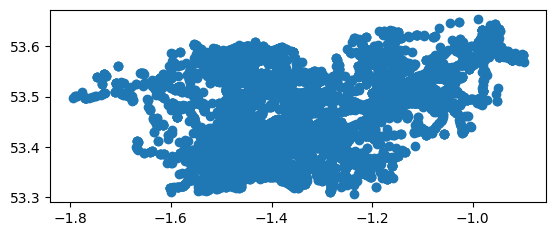

In [36]:
data = gpd.GeoDataFrame(data, geometry = gpd.points_from_xy(data.longitude, data.latitude))
data.crs = {'init': 'epsg:27700'}
data.plot()

In [37]:
data.drop(labels=['longitude', 'latitude', 'location_easting_osgr', 'location_northing_osgr'], axis=1, inplace=True)

In [38]:
data.to_csv('cleaned_dft_statistics_collision_and_casualty_last_5_years.csv', index=False)